# Notebook de modélisation
## Adrian Rodriguez
## Projet 4 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [2]:
import pandas as pd
pd.options.display.max_columns = None

from sklearn.decomposition import SparsePCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("default")
import pyLDAvis.sklearn

from functions import *

---
# 1. Importation et exploration préliminaire


In [3]:
questions_raw = pd.read_csv('src/cleaned_questions.csv')

In [4]:
questions_raw.head()

,Id,Tags,Title_Body,Cleaned_Title_Body
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...


In [5]:
questions_raw.shape

(49538, 4)

In [6]:
questions_raw.columns

Index(['Id', 'Tags', 'Title_Body', 'Cleaned_Title_Body'], dtype='object')

In [7]:
questions_raw.isna().sum()

Id                    0
Tags                  1
Title_Body            0
Cleaned_Title_Body    3
dtype: int64

In [8]:
questions = questions_raw.copy()

In [9]:
questions[questions.Cleaned_Title_Body.isna()]

,Id,Tags,Title_Body,Cleaned_Title_Body
19901,41069330,"javascript,html","With <script crossorigin='anonymous'>, why is ...",NaN
26594,38143580,"html,css",When should <script> tags be visible and why c...,NaN
46736,30727084,"javascript,jquery,autocomplete",Make <a> inside jQuery autocomplete clickable ...,NaN


In [10]:
# Je limite le nombre d'observation pour la phase de dev
questions = questions.head(10000)

# 2. Classification non supervisée avec LDA
Méthode : 
- 1/ Création du vecteur de mots
- 2/ Calcul du nombre de sujet idéal
- 3/ Formation du modèle
- 4/ Vérification des résultats

In [11]:
corpus = questions.Cleaned_Title_Body

## Création du vecteur de mots

In [12]:
count_vectorizer = CountVectorizer()
feature_matrix = count_vectorizer.fit_transform(corpus)
display(feature_matrix.shape)

(10000, 20361)

## Détermination du nombre de sujet idéal

In [258]:
results = pd.DataFrame()
tmp_result = pd.DataFrame(index = range(1))
for i in np.arange(5, 70, 5):
    print(f'{i} composants en cours de traitement...')
    lda_model = LatentDirichletAllocation(n_components=i, random_state=123)

    lda_model.fit_transform(feature_matrix)

    tmp_result['n_components'] = i
    tmp_result['log_likelihood'] = lda_model.score(feature_matrix)
    tmp_result['perplexity'] = lda_model.perplexity(feature_matrix)

    results = results.append(tmp_result)

results

5 composants en cours de traitement...
10 composants en cours de traitement...
15 composants en cours de traitement...
20 composants en cours de traitement...
25 composants en cours de traitement...
30 composants en cours de traitement...
35 composants en cours de traitement...
40 composants en cours de traitement...
45 composants en cours de traitement...
50 composants en cours de traitement...
55 composants en cours de traitement...
60 composants en cours de traitement...
65 composants en cours de traitement...


,n_components,log_likelihood,perplexity
0,5,-2.672466e+06,1820.799713
0,10,-2.673128e+06,1824.189340
0,15,-2.666520e+06,1790.640856
0,20,-2.669607e+06,1806.236672
0,25,-2.672728e+06,1822.143823
0,30,-2.671419e+06,1815.456202
0,35,-2.675996e+06,1838.946575
0,40,-2.679729e+06,1858.330978
0,45,-2.678335e+06,1851.070234
0,50,-2.686320e+06,1893.058846


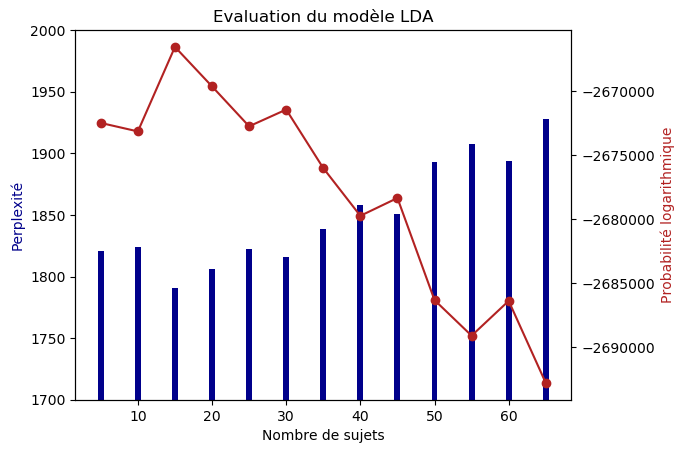

In [327]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(results.n_components,
        results.perplexity,
        color='darkblue')
ax2.plot(results.n_components,
         results.log_likelihood,
         'o-',
         color="firebrick")
min_y = int(results.perplexity.min()/100)*100
max_y = int((results.perplexity.max()+100)/100)*100
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('Nombre de sujets')
ax1.set_ylabel('Perplexité', color='darkblue')
ax2.set_ylabel('Probabilité logarithmique', color='firebrick')
plt.title('Evaluation du modèle LDA')
plt.savefig('img/img_LDA_evaluation.png',
            transparent=True)
plt.show()

Je cherche à avoir la probabilité logarithmique la plus élevée et une moindre perplexité.

## Formation du modèle

In [29]:
min_perp = results.perplexity.min()
n_comp = results[results.perplexity == min_perp].n_components.item()
print(f'Le nombre de sujet idéal est de {n_comp}')
# Je forme le modèle
lda = LatentDirichletAllocation(n_components=n_comp, random_state=123)
lda_out = lda.fit_transform(feature_matrix)

NameError: name 'results' is not defined

In [13]:
# Temporaire : pour éviter de relancer le calcul à chaque essai
lda = LatentDirichletAllocation(n_components=15, random_state=123)
lda_out = lda.fit_transform(feature_matrix)

In [14]:
# Sujet dominants dans chaque documents
doc_topic = get_doc_topic(lda, corpus, lda_out)
doc_topic

,Topic_#0,Topic_#1,Topic_#2,Topic_#3,Topic_#4,Topic_#5,Topic_#6,Topic_#7,Topic_#8,Topic_#9,Topic_#10,Topic_#11,Topic_#12,Topic_#13,Topic_#14
0,0.12,0.00,0.0,0.00,0.00,0.00,0.64,0.21,0.00,0.0,0.0,0.0,0.0,0.00,0.00
1,0.00,0.00,0.0,0.00,0.00,0.00,0.27,0.68,0.00,0.0,0.0,0.0,0.0,0.00,0.00
2,0.22,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.61,0.0,0.0,0.0,0.0,0.14,0.00
3,0.00,0.00,0.0,0.00,0.00,0.00,0.78,0.00,0.00,0.0,0.0,0.0,0.0,0.17,0.00
4,0.00,0.00,0.0,0.00,0.33,0.00,0.05,0.00,0.00,0.0,0.0,0.0,0.0,0.52,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,0.00,0.0,0.66,0.19,0.00,0.00,0.00,0.10,0.0,0.0,0.0,0.0,0.00,0.00
9996,0.19,0.00,0.0,0.00,0.00,0.26,0.00,0.00,0.00,0.0,0.5,0.0,0.0,0.00,0.00
9997,0.33,0.00,0.0,0.00,0.00,0.38,0.25,0.00,0.03,0.0,0.0,0.0,0.0,0.00,0.00
9998,0.00,0.98,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00


<Figure size 640x480 with 0 Axes>

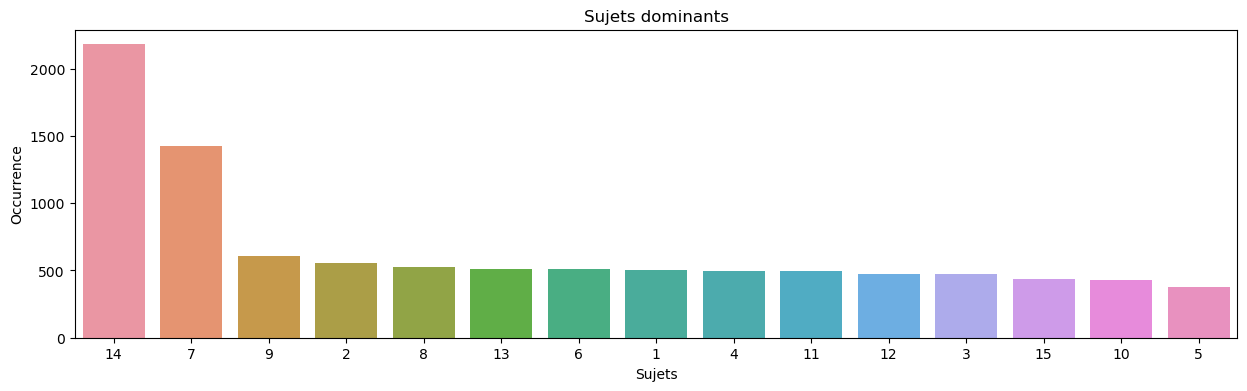

In [15]:
dominant_topic = doc_topic.copy()
dominant_topic['dominant_topic'] = np.argmax(dominant_topic.values, axis=1) + 1
order = dominant_topic.groupby('dominant_topic')['Topic_#1'].count().sort_values(ascending=False).index

plt.clf()
plt.figure(figsize=(15,4))
sns.countplot(dominant_topic.dominant_topic, order=order)
plt.title('Sujets dominants')
plt.xlabel('Sujets')
plt.ylabel('Occurrence')
plt.savefig('img/img_dominant_topic.png',
            transparent=True)

In [16]:
# Top mots clés des différents sujets.
topic_keywords = show_topics(count_vectorizer, lda, 5)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic_#' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic_#0,value,column,number,python,row
Topic_#1,component,react,state,hook,angular
Topic_#2,function,python,way,code,example
Topic_#3,model,kotlin,list,git,output
Topic_#4,angular,project,spring,version,java
Topic_#5,image,version,android,memory,way
Topic_#6,type,code,class,value,function
Topic_#7,object,string,type,datum,field
Topic_#8,android,app,request,service,api
Topic_#9,core,net,chrome,project,version


In [17]:
panel = pyLDAvis.sklearn.prepare(lda, feature_matrix, count_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'img/lda.html')
pyLDAvis.display(panel)

## Vérification des résultats
A partir des sujets dominants dans chaque documents et des 5 mots clés principaux de chaque sujets dominants, je constitue une suggestion de tags non supervisée.

In [18]:
pred_tag = get_unsupervised_tag(doc_topic, df_topic_keywords, corpus)
questions = pd.merge(questions, pred_tag, left_index=True, right_index=True)
questions

,Id,Tags,Title_Body,Cleaned_Title_Body,unsupervised_tag
0,63087217,"rust,reference",Changes using mutable reference of a field are...,change mutable reference field reflect origina...,"value,type,code,class,object"
1,63078532,javascript,Is it possible to create a new data type in Ja...,possible new data type javascript possible new...,"type,object,string,datum,field"
2,63067062,elasticsearch,Elastic Search indexes gets deleted frequently...,elastic search index delete frequently elastic...,"value,android,app,request,error"
3,63046397,"c++,if_statement,templates,c++17,constexpr",Why does this usage of C++17 if constexpr fail...,usage c++17 constexpr try c++17 constexpr cond...,"type,code,class,value,error"
4,63043585,"java,visual_studio_code","VSCode showing ""Java 11 or more recent is requ...",java recent require download recent jdk start ...,"angular,project,error,file,build"
...,...,...,...,...,...
9995,46428604,"python,tensorflow,neural_network",how to implement early stopping in tensorflow ...,early tensorflow neural network code music voi...,"model,kotlin,list,angular,android"
9996,46428420,docker_compose,"docker-compose up, down, stop start difference...",docker compose start difference find informati...,"value,image,xcode,ios,view"
9997,46426283,"java,javafx",Why is javafx mangling my semi-transparent cur...,javafx mangle semi - transparent cursor png im...,"value,column,image,version,type"
9998,46425633,"vue.js,vuejs2,vue_component",How to send updated values from Parent compone...,send value parent component child component pa...,"component,react,state,hook,angular"


---
---

# Classification supervisée
Je reprends le modèle réduit avec LDA et mes tags indiqué par l'utilisateur

In [19]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(corpus)
display(tfidf_feature_matrix.shape)

(10000, 20361)

In [20]:
target = questions.drop(columns=['Id', 'Title_Body', 'Cleaned_Title_Body'])
X_train, X_test, y_train, y_test = train_test_split(tfidf_feature_matrix, target, test_size=0.2, random_state=123)

In [21]:
y_test

,Tags,unsupervised_tag
2656,"javascript,node.js,webpack,babeljs","function,python,error,file,project"
445,"android,google_maps","type,android,app,request,service"
9505,"javascript,node.js,angular,typescript","angular,project,page,button,error"
332,"c#,lambda","component,react,type,code,class"
4168,"c#,.net,git,build,.net_core","model,angular,project,core,net"
...,...,...
8018,"c#,asp.net,asp.net_mvc","android,app,core,page,button"
6463,"java,exception_handling,nullpointerexception","function,python,way,code,object"
2883,"java,java_8,java_stream","image,version,type,code,test"
7895,elasticsearch,"object,string,type,datum,error"


In [22]:
lst_index = y_test.index.to_list()

## Classification multilabel

In [23]:
y_train_tags = [set(i.split(',')) for i in y_train.Tags]
y_test_tags = [set(i.split(',')) for i in y_test.Tags]

In [24]:
mlb = MultiLabelBinarizer()
# Reprise des tags originaux et test de inverse_transform
y_test_tags = mlb.fit_transform(y_test_tags)
y_test_tags_inversed = mlb.inverse_transform(y_test_tags)

# Mise en place la classification supervisée multilabel
y_train_tags = mlb.fit_transform(y_train_tags)

In [25]:
# TO DO : Classifier avec KNN, RFF, GB

In [26]:
y_test

,Tags,unsupervised_tag
2656,"javascript,node.js,webpack,babeljs","function,python,error,file,project"
445,"android,google_maps","type,android,app,request,service"
9505,"javascript,node.js,angular,typescript","angular,project,page,button,error"
332,"c#,lambda","component,react,type,code,class"
4168,"c#,.net,git,build,.net_core","model,angular,project,core,net"
...,...,...
8018,"c#,asp.net,asp.net_mvc","android,app,core,page,button"
6463,"java,exception_handling,nullpointerexception","function,python,way,code,object"
2883,"java,java_8,java_stream","image,version,type,code,test"
7895,elasticsearch,"object,string,type,datum,error"


In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [75]:
#classifier = [('LogisticRegression', LogisticRegression(C=1, penalty='l1', dual=False, solver='liblinear')),
#              ('LinearSVC', LinearSVC(C=1, penalty='l1', dual=False, loss='squared_hinge')), 
#              ('MultinomialNB', MultinomialNB(alpha=1.0))]

classifier = [('kNN', KNeighborsClassifier()),
              ('RandomForest', RandomForestClassifier()), 
              ('GradientBoosting', GradientBoostingClassifier())]

for clf_name, clf in classifier:
    print(f'Classification avec {clf_name}...')
    
    model = OneVsRestClassifier(clf)
    model.fit(X_train, y_train_tags)

    # TO DO : %time it / Bien dissocié temps de fit et temps de pred
    # TO DO : test le seuil de décision avec predict_proba
    y_pred = model.predict(X_test)

    y_pred_inversed = mlb.inverse_transform(y_pred)

    y_pred_inversed = transform_tuple(y_pred_inversed)
    y_test['supervised_tags_' + clf_name] = y_pred_inversed
    #y_pred_tag = pd.DataFrame(y_pred_inversed, columns=['supervised_tags'])
    #y_pred_tag['index'] = lst_index
    #y_pred_tag = y_pred_tag.set_index('index')
    
    # Comparaison des résultats
    # for i in lst_index[:10]:
    #    print(f'{corpus.loc[i]}\n\nTags originaux: {y_test.Tags[i]}\nTags non supervisés: {y_test.unsupervised_tag[i]}\nTags supervisés: {y_test["supervised_tags_" + clf_name].loc[i]}\n\n')
    
    print(f'Score de Jaccard pour {clf_name} : {get_jaccard_score(y_test.Tags, y_test["supervised_tags_" + clf_name])} %\n')
    # print('##################################################\n\n')

Classification avec kNN...
Score de Jaccard pour kNN : 27 %

Classification avec RandomForest...
Score de Jaccard pour RandomForest : 16 %

Classification avec GradientBoosting...
Score de Jaccard pour GradientBoosting : 35 %



# Version des packages

In [372]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("Numpy", numpy.__version__)
import pandas; print("Pandas", pandas.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import nltk; print("NLTK", nltk.__version__)
import requests; print("requests", requests.__version__)
import bs4; print("BeautifulSoup", bs4.__version__)
import re; print("re", re.__version__)
import spacy; print("spacy", spacy.__version__)
import gensim; print("gensim", gensim.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.0.3
Seaborn 0.10.0
Matplotlib 3.1.3
NLTK 3.5
requests 2.24.0
BeautifulSoup 4.8.2
re 2.2.1
spacy 2.3.2
gensim 3.8.0
